# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="images/bcamp.png" align="center">

## Using CUDA, Jupyter, PyCUDA and PyTorch

### 05 PyCUDA Image Processing

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="images/gtx.png" width="35%" align="center">

# PyCUDA Imports

In [3]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np

# imports
import numpy as np                     # numeric python lib
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour
import scipy.ndimage as ndi            # to determine shape centrality
# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots

import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"

import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from PIL import Image, ImageFilter
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import matplotlib.pyplot as plot   # Library to plot
import matplotlib.cm as colormap   # Library to plot
import PIL
from PIL import Image as PILImage
import time
%matplotlib inline

tensorflow:1.2.1


In [7]:
import caffe
from caffe import layers as L
from caffe import params as P
caffe.set_device(0)
caffe.set_mode_gpu()

from pycuda.compiler import SourceModule
import pycuda
from pycuda import compiler
import pycuda.driver as cuda
import pycuda.autoinit             # PyCuda autoinit
import pycuda.driver as cuda       # PyCuda In, Out helpers
import matplotlib.pyplot as plot   # Library to plot
import matplotlib.cm as colormap   # Library to plot
import numpy                       # Fast math library
import time
print("%d device(s) found." % cuda.Device.count())           
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print "Device #%d: %s" % (ordinal, dev.name())    
print cuda

1 device(s) found.
Device #0: GeForce GTX 1080
<module 'pycuda.driver' from '/usr/local/lib/python2.7/dist-packages/pycuda/driver.pyc'>


# Read an Image using PIL

(7600, 10700, 3)
uint8
<type 'numpy.ndarray'>


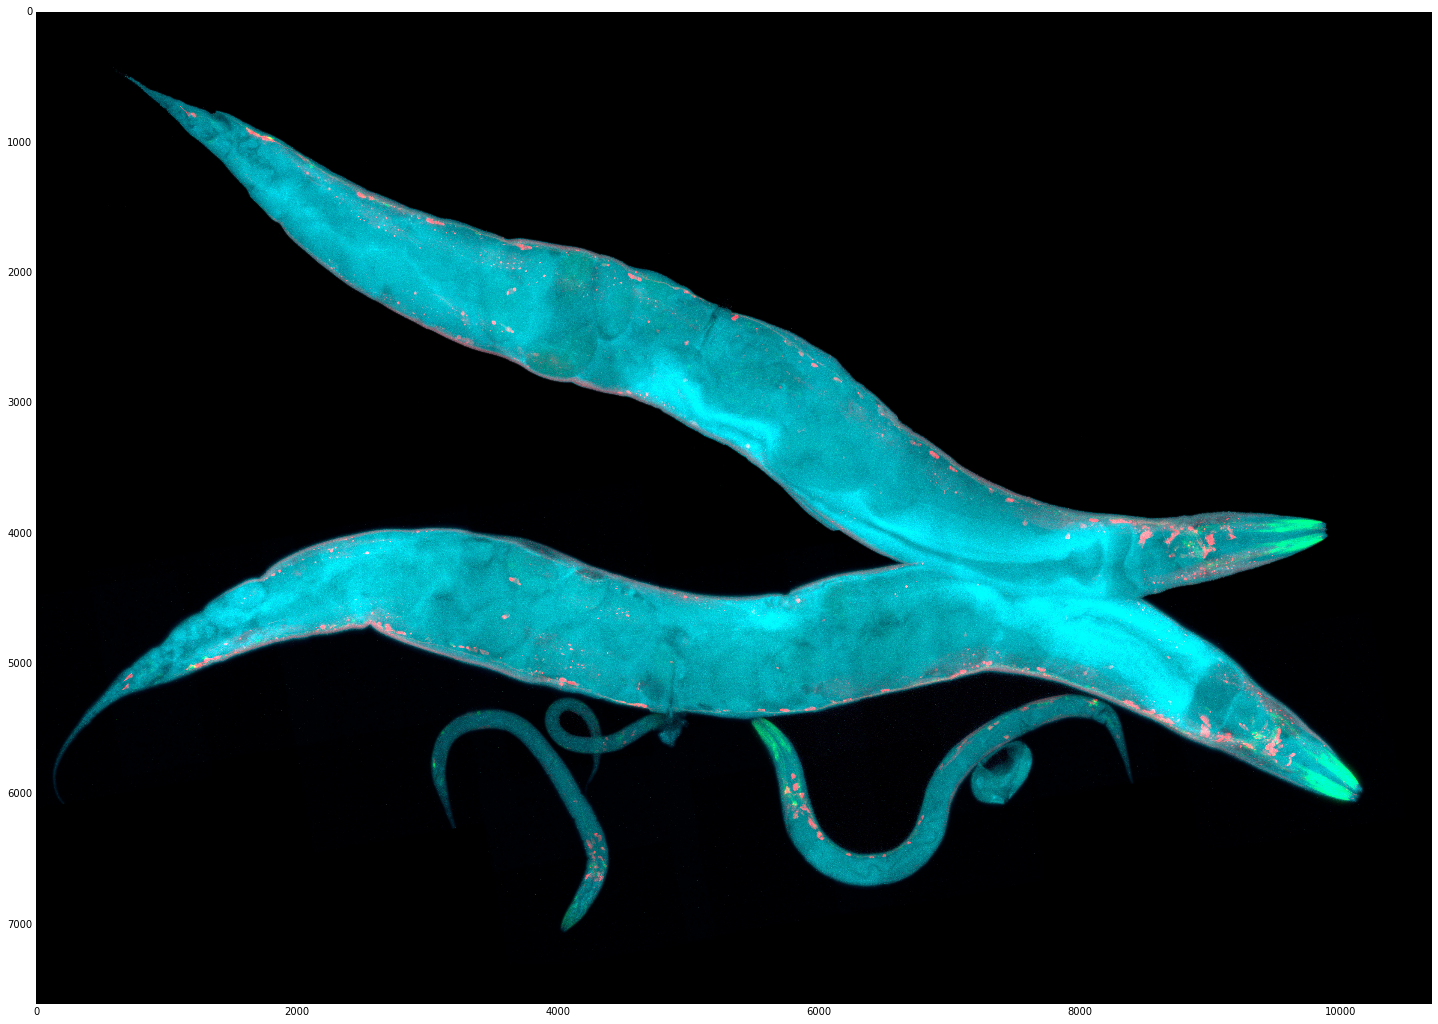

In [5]:
from scipy.misc import imread, imsave
# im = imread('images/test40mb.jpg', flatten=False).astype(np.float32)
im = imread('images/nematode.jpg', flatten=False)
print im.shape 
print im.dtype
print str (type(im))
figure = plot.figure()
figure.set_size_inches(25, 25)
imshow(im)

# A CUDA based BW Kernel

In [8]:
 #Kernel text
kernel = """
 
    __global__ void bw( float *inIm, int check ){
 
        int idx = (threadIdx.x ) + blockDim.x * blockIdx.x ;
 
        if(idx *3 < check*3)
        {
        int val = 0.21 *inIm[idx*3] + 0.71*inIm[idx*3+1] + 0.07 * inIm[idx*3+2];
        //int val = (inIm[idx*3] + inIm[idx*3+1] + inIm[idx*3+2])/3.0;
 
        inIm[idx*3]= val;
        inIm[idx*3+1]= val;
        inIm[idx*3+2]= val;
        }
    }
    """
 
#Compile and get kernel function
mod = SourceModule(kernel)
print mod
func = mod.get_function("bw")
print func

In [12]:
import PIL
from PIL import Image as PILImage

def filterImageOnGPU(inPath, filterFunc):              
    im = PILImage.open(inPath)            
    px = numpy.array(im).astype(numpy.float32)
        
    print 'Size:' + str(im.size)
    print 'Pixels:' + str (im.size[0]*im.size[1])
    
    d_px = cuda.mem_alloc(px.nbytes)
    cuda.memcpy_htod(d_px, px)
      
    BLOCK_SIZE = 1024
    block = (BLOCK_SIZE,1,1)
    print ('Block:' + str (block))
    totalPixels = numpy.int32(im.size[0]*im.size[1])
    print ('TotalPixels:' + str (totalPixels))
    gridRounded=int(im.size[0]*im.size[1]/BLOCK_SIZE)+1
    print ('GridRounded:' + str (gridRounded))
    print ('BLOCK_SIZE * GridRounded:' + str (gridRounded*BLOCK_SIZE))
    grid = (gridRounded,1,1)
    print ('Grid:' + str (grid))
   
    filterFunc(d_px,totalPixels, block=block,grid = grid)
   
    bwPx = numpy.empty_like(px)
    cuda.memcpy_dtoh(bwPx, d_px)
    # On monochrome images, Pixels are uint8 [0,255].    
#     numpy.clip(bwPx, 0, 255, out=bwPx)
#     bwPx = bwPx.astype('uint8')
    bwPx = (numpy.uint8(bwPx))       
    pil_im = PILImage.fromarray(bwPx,mode ="RGB")           
    return pil_im

# Timing util

In [13]:
import sys
start_time=0.0

def startTimer(funcname):
    global start_time    
    print(funcname)        
    start_time = time.time()
        
def stopTimer():
    elapsed_time = time.time() - start_time    
    print 'DONE in {0:.8f} seconds.'.format(elapsed_time)      

# Timing Numpy vs. PyCUDA ...

filterImageOnGPU
Size:(10700, 7600)
Pixels:81320000
Block:(1024, 1, 1)
TotalPixels:81320000
GridRounded:79415
BLOCK_SIZE * GridRounded:81320960
Grid:(79415, 1, 1)
DONE in 1.76085901 seconds.


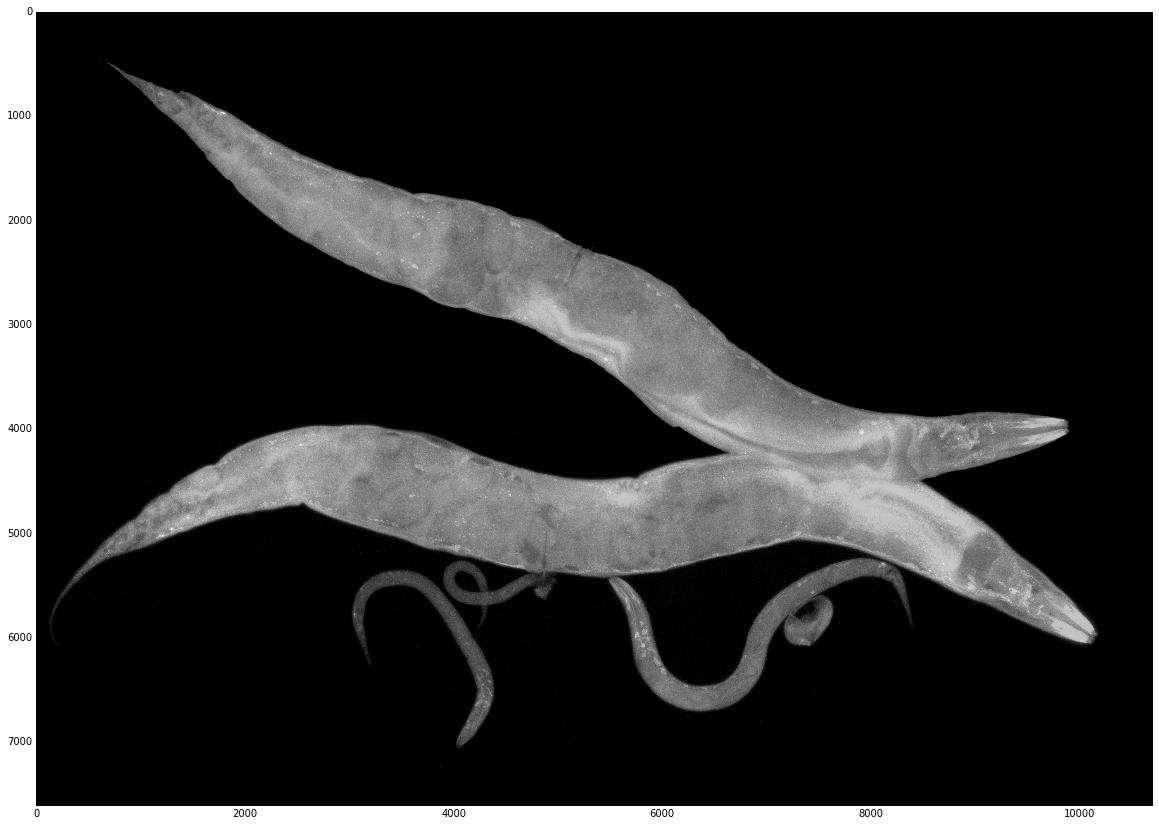

In [14]:
startTimer('filterImageOnGPU')
figure = plot.figure()
figure.set_size_inches(20, 20)
imshow(filterImageOnGPU('images/nematode.jpg',func))
stopTimer()  

# import timeit
# n_iter = ARR_SIZE
# rounds = 1000  # for timeit

# print 'numpy', timeit.timeit(lambda: 
#                               expit(a), 
#                               number=rounds)

# print 'pycuda', timeit.timeit(lambda: 
#                               sigmoidGPU(), 
#                               number=rounds)